In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, lognorm, binom
from matplotlib import pyplot as plt

from pynba import halfgames_from_possessions, possessions_from_file, seasons_on_file, use_blackontrans_style
from pynba.halfgames import estimate_shots_per_opp, estimate_shots_per_poss, calc_scoring_rate


use_blackontrans_style()

In [2]:
seasons = seasons_on_file()

possessions = pd.concat([
    possessions_from_file(league, year, season_type)
    for league, year, season_type
    in zip(seasons["league"], seasons["year"], seasons["season_type"])
    if ((league == "nba") & (season_type == "Regular Season"))
], ignore_index=True)

halfgames = halfgames_from_possessions(possessions)

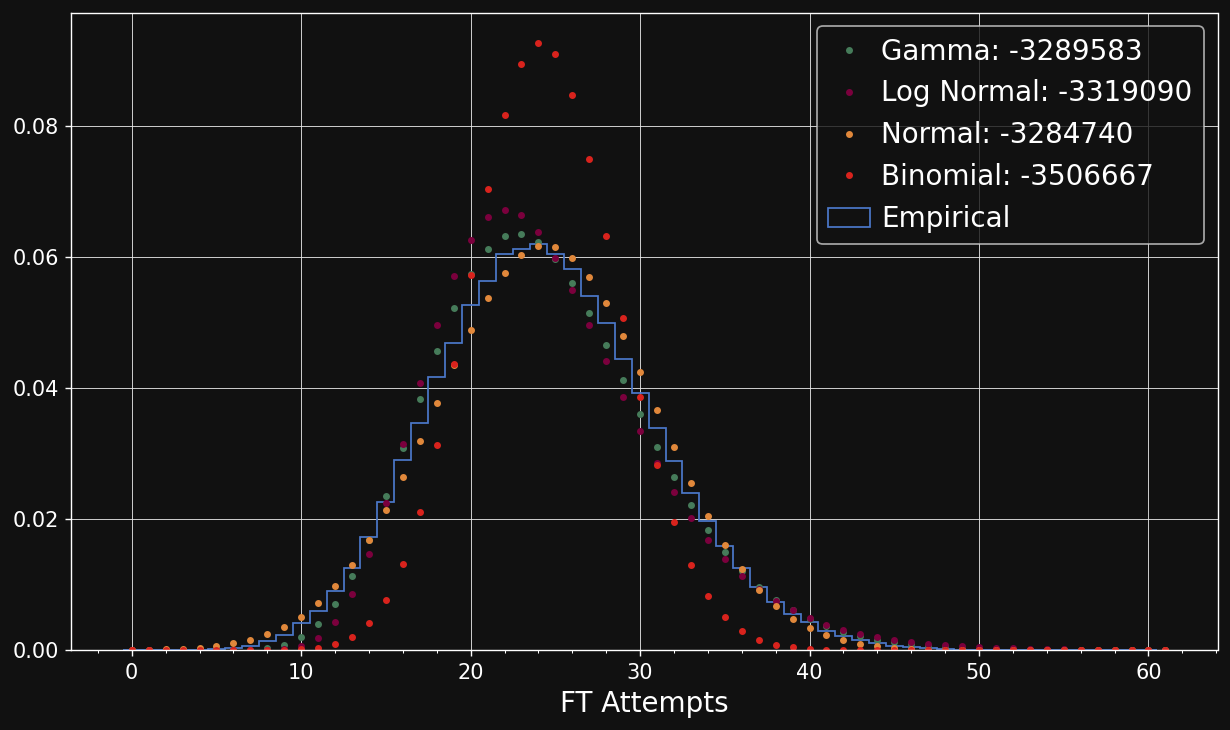

In [6]:
n_trials = 1000000
n_possessions = 100

ft_attempted = possessions['ft_attempted'].value_counts().sort_index().values / possessions.shape[0]

ft_sims = np.random.choice(ft_attempted.shape[0], size=(n_trials, n_possessions), p=ft_attempted).sum(1)
support = np.arange(ft_sims.max())
mu = ft_sims.mean()
sigma = ft_sims.std()

gamma_dist = gamma(a=mu ** 2 / sigma ** 2, scale=sigma ** 2 / mu)
lognorm_dist = lognorm(s=np.sqrt(np.log(1 + sigma ** 2 / mu ** 2)), scale=mu ** 2 / np.sqrt(sigma ** 2 + mu ** 2))
norm_dist = norm(loc=mu, scale=sigma)
binom_dist = binom(n=n_possessions, p=mu / n_possessions)

gamma_score = gamma_dist.logpdf(ft_sims).sum()
lognorm_score = lognorm_dist.logpdf(ft_sims).sum()
norm_score = norm_dist.logpdf(ft_sims).sum()
binom_score = binom_dist.logpmf(ft_sims).sum()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(ft_sims, bins=support, rwidth=0.8, label='Empirical', density=True, histtype='step', align='left')
ax.plot(support, gamma_dist.pdf(support), '.', label=f'Gamma: {gamma_score:.0f}')
ax.plot(support, lognorm_dist.pdf(support), '.', label=f'Log Normal: {lognorm_score:.0f}')
ax.plot(support, norm_dist.pdf(support), '.', label=f'Normal: {norm_score:.0f}')
ax.plot(support, binom_dist.pmf(support), '.', label=f'Binomial: {binom_score:.0f}')
ax.set_xlabel('FT Attempts')
ax.legend();

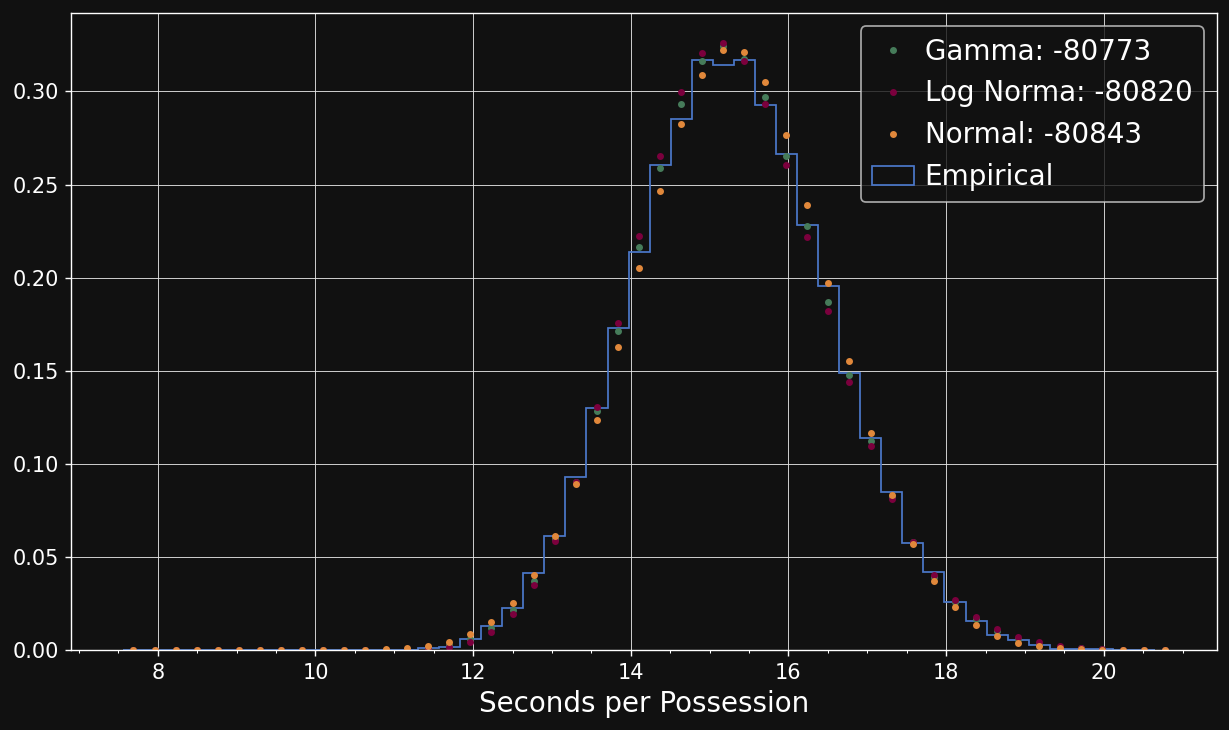

In [4]:
pace = halfgames['pace']

support = np.linspace(pace.min(), pace.max())
shift = (support[-1] - support[0]) / support.shape[0] / 2
x = support + shift
mu = pace.mean()
sigma = pace.std()

gamma_dist = gamma(a=mu ** 2 / sigma ** 2, scale=sigma ** 2 / mu)
lognorm_dist = lognorm(s=np.sqrt(np.log(1 + sigma ** 2 / mu ** 2)), scale=mu ** 2 / np.sqrt(sigma ** 2 + mu ** 2))
norm_dist = norm(loc=mu, scale=sigma)

gamma_score = gamma_dist.logpdf(pace).sum()
lognorm_score = lognorm_dist.logpdf(pace).sum()
norm_score = norm_dist.logpdf(pace).sum()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(pace, bins=support, label='Empirical', density=True, histtype='step')
ax.plot(x, gamma_dist.pdf(x), '.', label=f'Gamma: {gamma_score:.0f}')
ax.plot(x, lognorm_dist.pdf(x), '.', label=f'Log Norma: {lognorm_score:.0f}')
ax.plot(x, norm_dist.pdf(x), '.', label=f'Normal: {norm_score:.0f}')
ax.set_xlabel('Seconds per Possession')
ax.legend();

In [5]:
filt = halfgames['off_team_id'] == halfgames['home_team_id']
home_hg = halfgames[filt]
away_hg = halfgames[~filt]

home_three_make_rate = home_hg['threes_made'].sum() / home_hg['threes_attempted'].sum()
home_two_make_rate = home_hg['twos_made'].sum() / home_hg['twos_attempted'].sum()
home_three_attempt_rate = home_hg['threes_attempted'].sum() / (home_hg['twos_attempted'].sum() + home_hg['threes_attempted'].sum())
home_ft_attempt_rate = home_hg['ft_attempted'].sum() / home_hg['possession_num'].sum()
home_ft_make_rate = home_hg['ft_made'].sum() / home_hg['ft_attempted'].sum()
home_off_reb_rate = home_hg['off_rebs'].sum() / (home_hg['off_rebs'].sum() + home_hg['def_rebs'].sum())
home_turnover_rate = home_hg['turnovers'].sum() / home_hg['possession_num'].sum()
home_pace = home_hg['duration'].sum() / home_hg['possession_num'].sum()
home_shots_per_opp = (home_hg['threes_attempted'].sum() + home_hg['twos_attempted'].sum()) / (home_hg['off_rebs'].sum() + home_hg['possession_num'].sum())
home_shots_per_poss = (home_hg['twos_attempted'].sum() + home_hg['threes_attempted'].sum()) / home_hg['possession_num'].sum()
home_scoring_rate = home_hg['points_scored'].sum() / home_hg['possession_num'].sum()
home_est_shots_per_opp = estimate_shots_per_opp(home_turnover_rate, home_ft_attempt_rate)
home_est_shots_per_poss = estimate_shots_per_poss(home_est_shots_per_opp, home_three_attempt_rate, home_three_make_rate, home_two_make_rate, home_off_reb_rate)
home_est_scoring_rate = calc_scoring_rate(home_est_shots_per_poss, home_three_make_rate, home_two_make_rate, home_three_attempt_rate, home_ft_attempt_rate, home_ft_make_rate)

away_three_make_rate = away_hg['threes_made'].sum() / away_hg['threes_attempted'].sum()
away_two_make_rate = away_hg['twos_made'].sum() / away_hg['twos_attempted'].sum()
away_three_attempt_rate = away_hg['threes_attempted'].sum() / (away_hg['twos_attempted'].sum() + away_hg['threes_attempted'].sum())
away_ft_attempt_rate = away_hg['ft_attempted'].sum() / away_hg['possession_num'].sum()
away_ft_make_rate = away_hg['ft_made'].sum() / away_hg['ft_attempted'].sum()
away_off_reb_rate = away_hg['off_rebs'].sum() / (away_hg['off_rebs'].sum() + away_hg['def_rebs'].sum())
away_turnover_rate = away_hg['turnovers'].sum() / away_hg['possession_num'].sum()
away_pace = away_hg['duration'].sum() / away_hg['possession_num'].sum()
away_shots_per_opp = (away_hg['threes_attempted'].sum() + away_hg['twos_attempted'].sum()) / (away_hg['off_rebs'].sum() + away_hg['possession_num'].sum())
away_shots_per_poss = (away_hg['twos_attempted'].sum() + away_hg['threes_attempted'].sum()) / away_hg['possession_num'].sum()
away_scoring_rate = away_hg['points_scored'].sum() / away_hg['possession_num'].sum()
away_est_shots_per_opp = estimate_shots_per_opp(away_turnover_rate, away_ft_attempt_rate)
away_est_shots_per_poss = estimate_shots_per_poss(away_est_shots_per_opp, away_three_attempt_rate, away_three_make_rate, away_two_make_rate, away_off_reb_rate)
away_est_scoring_rate = calc_scoring_rate(away_est_shots_per_poss, away_three_make_rate, away_two_make_rate, away_three_attempt_rate, away_ft_attempt_rate, away_ft_make_rate)

print(f'Three Make Rate: {home_three_make_rate * 1e2:.1f}% - {away_three_make_rate * 1e2:.1f}% ')
print(f'Two Make Rate: {home_two_make_rate * 1e2:.1f}% - {away_two_make_rate * 1e2:.1f}% ')
print(f'FT Attempt Rate: {home_ft_attempt_rate * 1e2:.1f} - {away_ft_attempt_rate * 1e2:.1f}')
print(f'FT Make Rate: {home_ft_make_rate * 1e2:.1f}% - {away_ft_make_rate * 1e2:.1f}% ')
print(f'Off Reb Rate: {home_off_reb_rate * 1e2:.1f}% - {away_off_reb_rate * 1e2:.1f}% ')
print(f'Turnover Rate: {home_turnover_rate * 1e2:.1f}% - {away_turnover_rate * 1e2:.1f}% ')
print(f'Pace: {home_pace:.1f}s - {away_pace:.1f}s ')
print(f'Shots per Opportunity: {home_shots_per_opp * 1e2:.1f} - {away_shots_per_opp * 1e2:.1f} ')
print(f'Shots per Possession: {home_shots_per_poss * 1e2:.1f} - {away_shots_per_poss * 1e2:.1f} ')
print(f'Scoring Rate: {home_scoring_rate * 1e2:.1f} - {away_scoring_rate * 1e2:.1f} ')
print(f'Estimated Shots per Opportunity: {home_est_shots_per_opp * 1e2:.1f} - {away_est_shots_per_opp * 1e2:.1f} ')
print(f'Estimated Shots per Possession: {home_est_shots_per_poss * 1e2:.1f} - {away_est_shots_per_poss * 1e2:.1f} ')
print(f'Estimated Scoring Rate: {home_est_scoring_rate * 1e2:.1f} - {away_est_scoring_rate * 1e2:.1f} ')

Three Make Rate: 36.1% - 35.3% 
Two Make Rate: 49.2% - 47.9% 
FT Attempt Rate: 24.9 - 23.9
FT Make Rate: 75.8% - 75.6% 
Off Reb Rate: 28.6% - 27.6% 
Turnover Rate: 15.0% - 15.3% 
Pace: 15.2s - 15.3s 
Shots per Opportunity: 76.2 - 76.3 
Shots per Possession: 86.8 - 86.8 
Scoring Rate: 106.5 - 103.5 
Estimated Shots per Opportunity: 77.3 - 77.4 
Estimated Shots per Possession: 87.8 - 87.8 
Estimated Scoring Rate: 107.5 - 104.5 
